In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import log_loss
from sklearn.tree import plot_tree
from scipy.spatial.distance import mahalanobis
import scipy
import imblearn
from imblearn.over_sampling import SMOTE
from scipy import stats
import math

In [2]:
### reading data into notebook
train_identity = pd.read_csv(r'train_identity.csv')
test_identity = pd.read_csv(r'test_identity.csv')
test_transaction = pd.read_csv(r'test_transaction.csv')
train_transaction = pd.read_csv(r'train_transaction.csv')

trainDF = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
testDF = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')

#print features
print("Features in train:\n", trainDF.columns.tolist())
print(trainDF.dtypes)
print("\nFeatures in test:\n", testDF.columns.tolist())
print(testDF.dtypes)

#fixing timestamps
trainDF['TransactionDay'] = (trainDF['TransactionDT'] // 86400).astype(int)
trainDF['TransactionDayOfWeek'] = trainDF['TransactionDay'] % 7
trainDF['TransactionWeek'] = (trainDF['TransactionDT'] // 604800).astype(int)

Features in train:
 ['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V7

In [3]:
#showing columns with # entries > 80% being null/empty
print("Top Features filled with N/A and Their Percentages")
trainDF.isnull().mean()[trainDF.isnull().mean() > .8]
#much of dataset is empty

Top Features filled with N/A and Their Percentages


dist2    0.936284
D6       0.876068
D7       0.934099
D8       0.873123
D9       0.873123
           ...   
id_27    0.991247
id_30    0.868654
id_32    0.868619
id_33    0.875895
id_34    0.868248
Length: 74, dtype: float64

# -------------------------------------------------------------------------------------

# Fraud Count Analysis

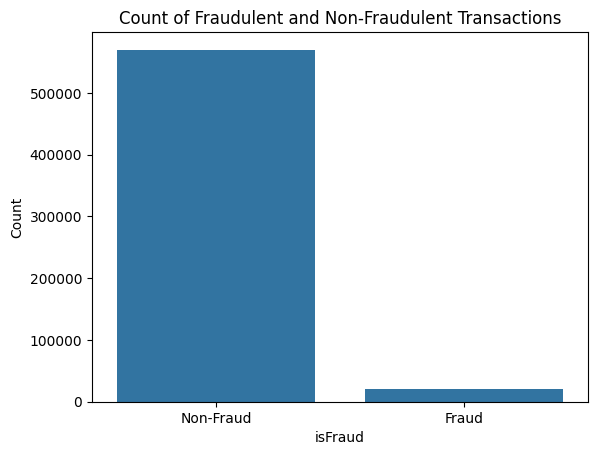

Percentage of Fraudulent Transactions: 0.03499000914417313


In [4]:
#Showing Distribution of Fraudulent vs Non-Fraudulent Transactions
fraud_counts = trainDF['isFraud'].value_counts()
sns.barplot(x=fraud_counts.index.map({0:"Non-Fraud", 1:"Fraud"}), y=fraud_counts.values)
plt.ylabel('Count')
plt.title('Count of Fraudulent and Non-Fraudulent Transactions')
plt.show()
print("Percentage of Fraudulent Transactions:", trainDF.isFraud.mean())
#Around 4 percent is flagged fraud 

In [5]:
#Correlation between transaction amount and fraudulent classification of transactions.
correlation = trainDF['TransactionAmt'].corr(trainDF['isFraud'])
print("Correlation between transaction amount and fraud flag:", correlation)
#Violates our hypothesis of there being immense correlation between TransactionAmt and fraud. Potentially indicates 
#most fraudulent transactions contain smaller transaction amounts to attempt to have less attention towards it.

Correlation between transaction amount and fraud flag: 0.01131982533321524


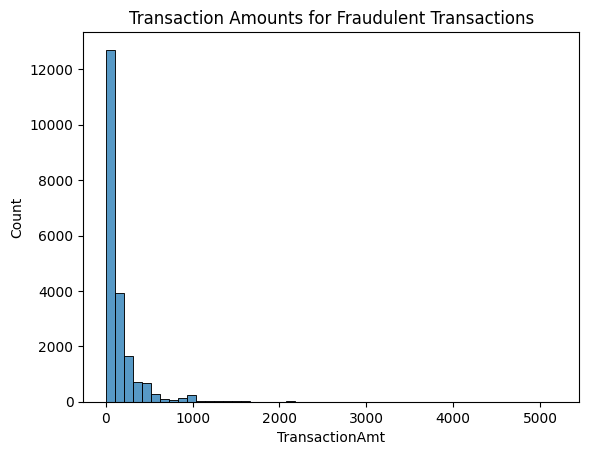

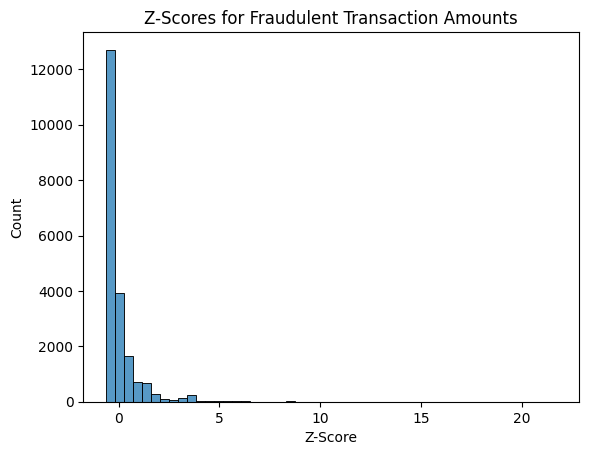

In [6]:
#Graphs of Transaction Amounts of Fraudulent Transactions + Z-scores for Fraudulent Transaction Amounts
fraudulent_transactions = trainDF[trainDF['isFraud']==1]
transaction_amounts = fraudulent_transactions['TransactionAmt']
z_scores = stats.zscore(transaction_amounts)

outliers = fraudulent_transactions[(z_scores > 3)|(z_scores < -3)]

sns.histplot(transaction_amounts, bins=50)
plt.title('Transaction Amounts for Fraudulent Transactions')
plt.show()

sns.histplot(z_scores, bins=50)
plt.title('Z-Scores for Fraudulent Transaction Amounts')
plt.xlabel('Z-Score')
plt.show()
#This further proves the hypothesis made in the last cell, most fraudulent transactions are in the lower end of transaction amounts.

# -------------------------------------------------------------------------------------

# Transaction Amount Analysis

In [7]:
#Ratio of Fraud Transactions in Long-Tail Transactions by Transaction Amount
long_tail_threshold = trainDF['TransactionAmt'].quantile(0.99)
long_tail_data = trainDF[trainDF['TransactionAmt'] > long_tail_threshold]
long_tail_fraud_ratio = long_tail_data['isFraud'].mean()
print(f"Fraud Ratio in Long-Tail Transactions: {long_tail_fraud_ratio}")
#Only 2% of fraudulent transactions took place in long-tail transaction amounts, thus most fraud was not in long-tail data. 

Fraud Ratio in Long-Tail Transactions: 0.024109200496365894


In [8]:
mean_transaction_amt = trainDF['TransactionAmt'].mean()
std_transaction_amt = trainDF['TransactionAmt'].std()
trainDF['TransactionAmt_Zscore'] = (trainDF['TransactionAmt'] - mean_transaction_amt) / std_transaction_amt
print(trainDF[['TransactionAmt', 'TransactionAmt_Zscore']].head())
outliersZScore = trainDF[(trainDF['TransactionAmt_Zscore'] > 3) | (trainDF['TransactionAmt_Zscore'] < -3)]
print(f"Number of outliers: {outliersZScore.shape[0]}")
print(outliersZScore[['TransactionID', 'TransactionAmt', 'TransactionAmt_Zscore']])

   TransactionAmt  TransactionAmt_Zscore
0            68.5              -0.278167
1            29.0              -0.443327
2            59.0              -0.317889
3            50.0              -0.355520
4            50.0              -0.355520
Number of outliers: 10093
        TransactionID  TransactionAmt  TransactionAmt_Zscore
60            2987060         2454.00               9.696222
110           2987110         1153.95               4.260378
133           2987133         2594.95              10.285570
135           2987135         3000.00              11.979188
163           2987163          973.95               3.507752
...               ...             ...                    ...
590402        3577402         1331.00               5.000670
590405        3577405         2286.27               8.994899
590408        3577408         1615.74               6.191241
590464        3577464         1731.30               6.674427
590519        3577519         1659.95               6.376

# -------------------------------------------------------------------------------------

# Credit Card Distributor Analysis

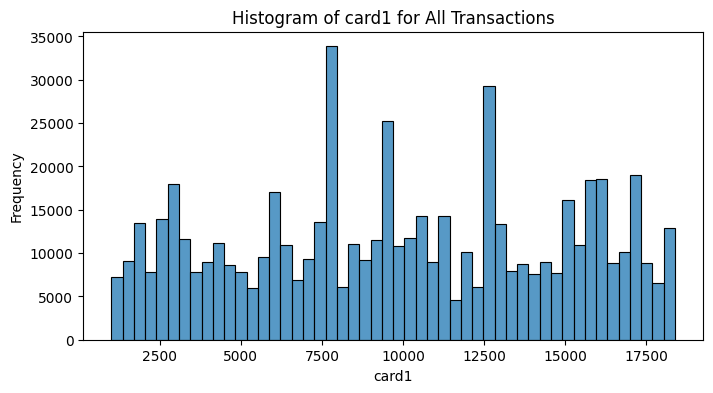

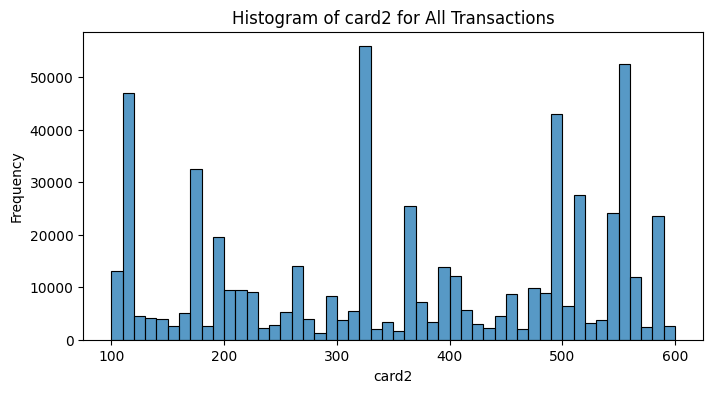

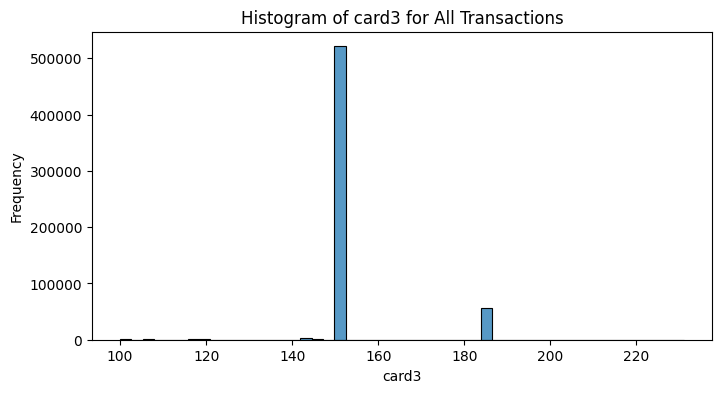

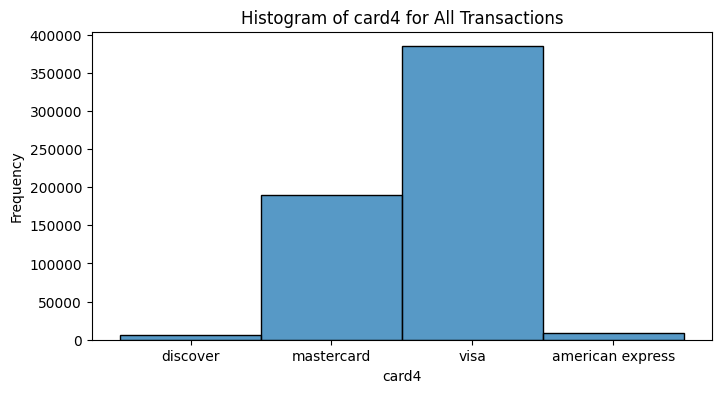

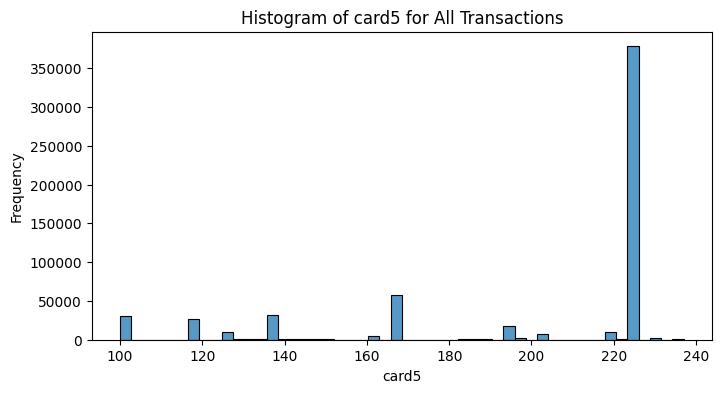

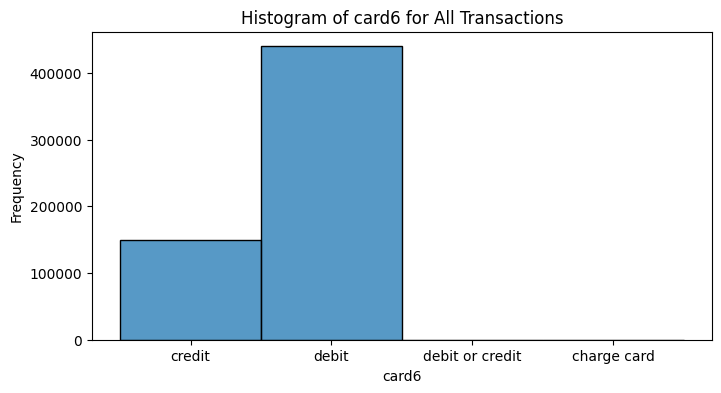

In [9]:
card_columns = ['card1', 'card2', 'card3', 'card4', 'card5', 'card6'] 
#categorical variables, with all transactions having card1, card2 less than card1, card3 less than card2
#card4 is credit card distributor, #card5-country, #card6- card type.
for card in card_columns:
    plt.figure(figsize=(8, 4))
    sns.histplot(trainDF[card].dropna(), kde=False, bins=50)  # Drop NaNs before plotting
    plt.title(f'Histogram of {card} for All Transactions')
    plt.xlabel(f'{card}')
    plt.ylabel('Frequency')
    plt.show()
#most used digital payments companies are Visa and Mastercard, this is expected to hold for fraudulent transactions as well. 

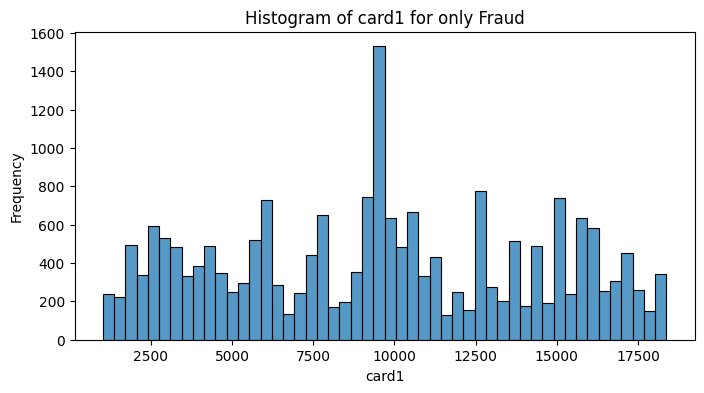

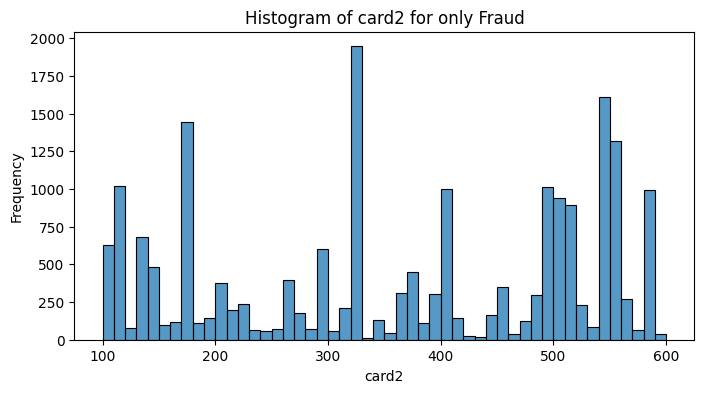

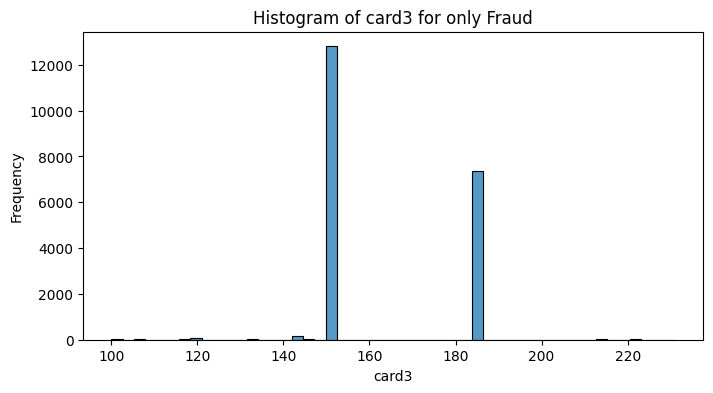

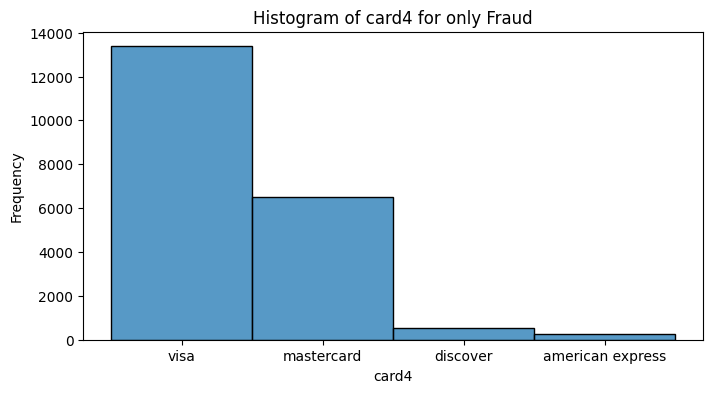

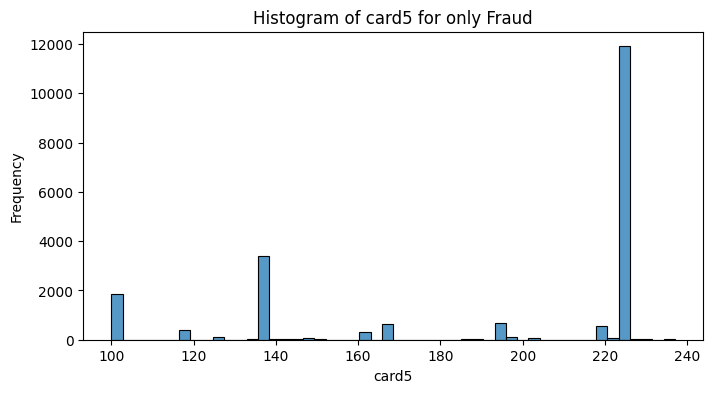

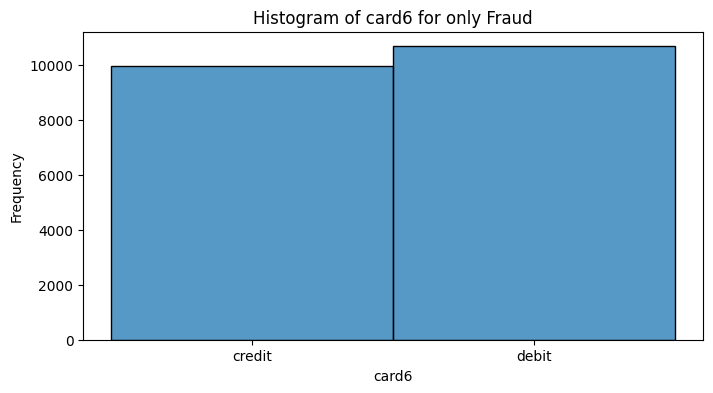

In [10]:
fraudDF = trainDF[trainDF['isFraud'] == 1]
for card in card_columns:
    plt.figure(figsize=(8, 4))
    sns.histplot(fraudDF[card].dropna(), kde=False, bins=50)  # Drop NaNs before plotting
    plt.title(f'Histogram of {card} for only Fraud')
    plt.xlabel(f'{card}')
    plt.ylabel('Frequency')
    plt.show()
#Like before Visa and Mastercard hold the highest representation in fraudulent transactions as well. 
#credit and debit hold similar rates of fraud. 

# -------------------------------------------------------------------------------------

# Email Domain Analysis (For Purchaser and Merchant)

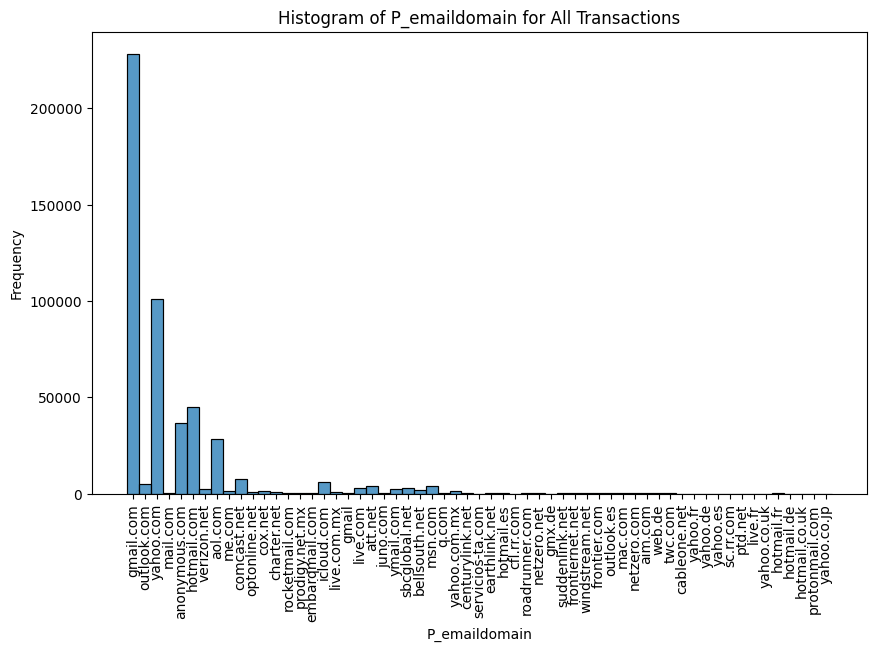

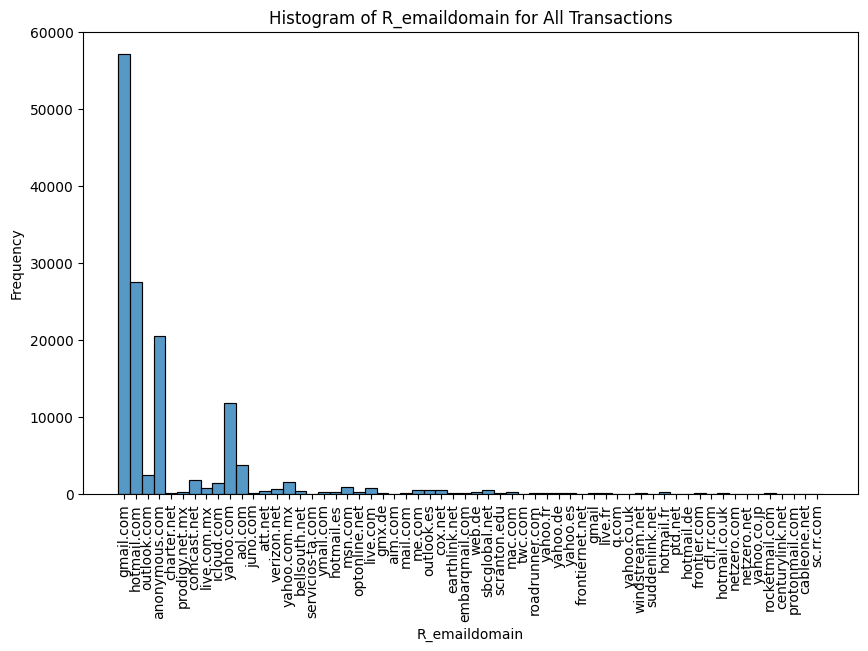

In [11]:
email_columns = ['P_emaildomain', 'R_emaildomain']
for email_col in email_columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(trainDF[email_col].dropna(), kde=False)  # Drop NaNs before plotting
    plt.title(f'Histogram of {email_col} for All Transactions')
    plt.xlabel(f'{email_col}')
    plt.ylabel('Frequency')
    plt.xticks(rotation=90)
    plt.show()
#We expect the two graphs to look similar as gmail has been dominating the email domain field for years and is used in practice
#by millions of corporations and individuals, whether they are purchasing or selling in a transaction.

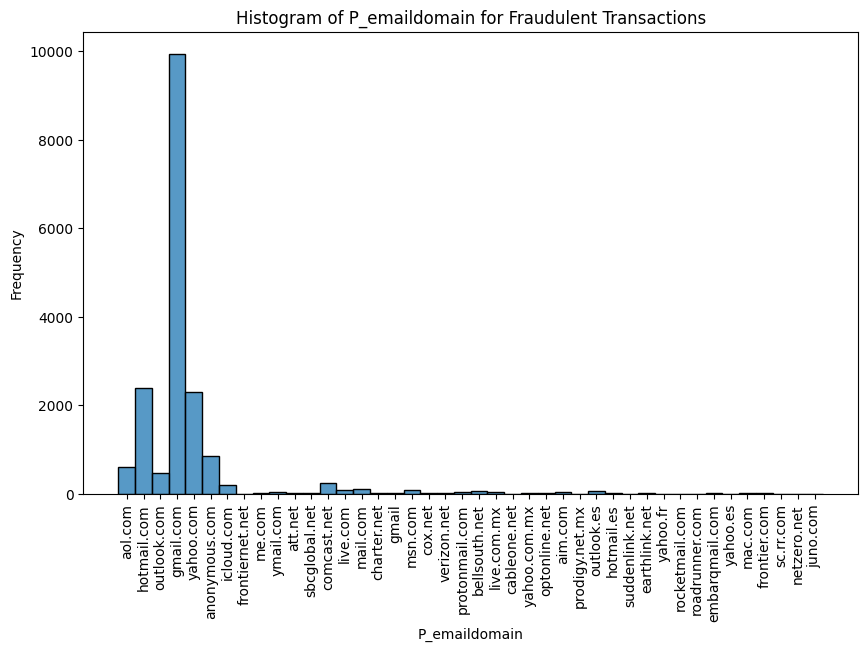

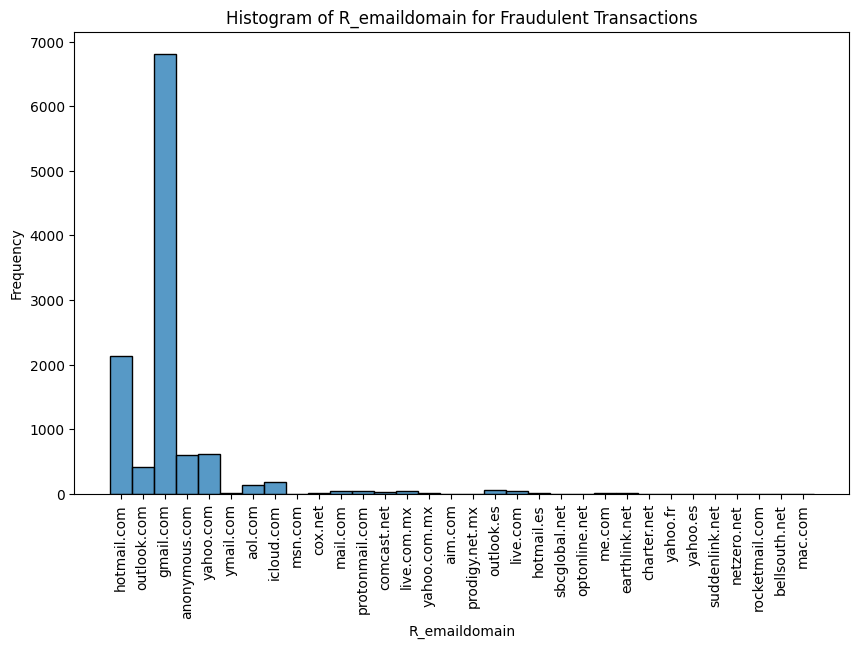

In [12]:
email_columns = ['P_emaildomain', 'R_emaildomain']
for email_col in email_columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(fraudDF[email_col].dropna(), kde=False)  # Drop NaNs before plotting
    plt.title(f'Histogram of {email_col} for Fraudulent Transactions')
    plt.xlabel(f'{email_col}')
    plt.ylabel('Frequency')
    plt.xticks(rotation=90)
    plt.show()
#Satisfies hypothesis from last cell, gmail is still #1 regardless of fraudulent or not transaction.

# -------------------------------------------------------------------------------------

# Address/Distance Analysis

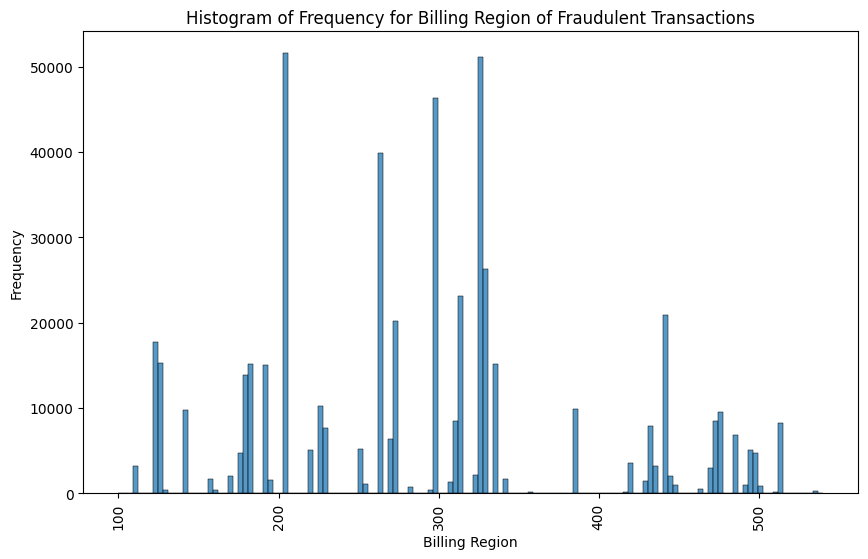

In [13]:
plt.figure(figsize=(10, 6))
sns.histplot(trainDF['addr1'].dropna(), kde=False)  # Drop NaNs before plotting
plt.title(f'Histogram of Frequency for Billing Region of Fraudulent Transactions')
plt.xlabel('Billing Region')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()
#We expect fraud to take place all over the country due to the ability to falsify billing addresses. The first graph refers to
#billing region, second refers to which country.

In [14]:
addressIsFraud = trainDF.groupby('addr1').isFraud.mean().sort_values(ascending=False)
print("Percentage Occurences of Fraud by Billing Region:")
addressIsFraud.head(10)

Percentage Occurences of Fraud by Billing Region:


addr1
305.0    0.666667
483.0    0.565217
501.0    0.500000
466.0    0.500000
471.0    0.500000
391.0    0.457143
431.0    0.342105
260.0    0.333333
432.0    0.289474
216.0    0.240741
Name: isFraud, dtype: float64

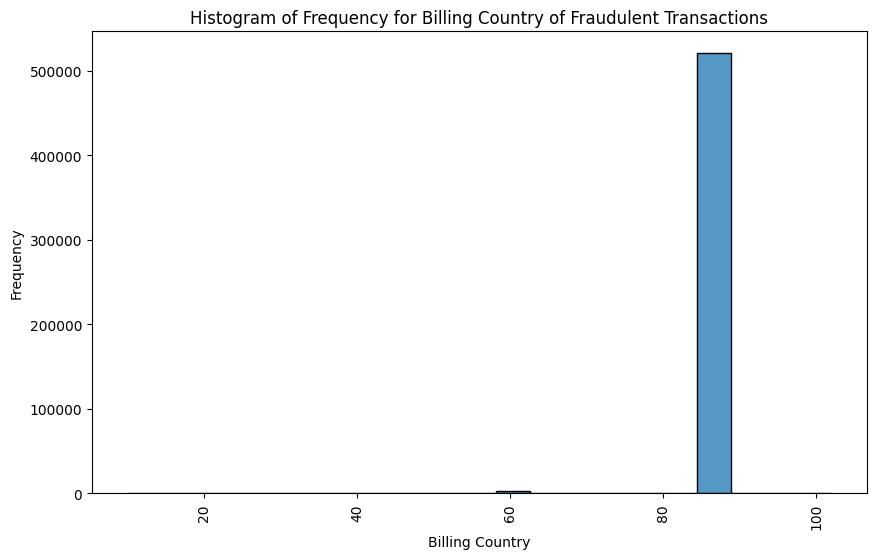

In [15]:
plt.figure(figsize=(10, 6))
sns.histplot(trainDF['addr2'].dropna(), kde=False)  # Drop NaNs before plotting
plt.title(f'Histogram of Frequency for Billing Country of Fraudulent Transactions')
plt.xlabel('Billing Country')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()
#it can be seen that nearly all transactions from this dataset were taken from one country, it can be assumed to be 
#the US due to usage of Mastercard, Visa, American Express, etc... (Country 87)

# -------------------------------------------------------------------------------------

# Date and Time

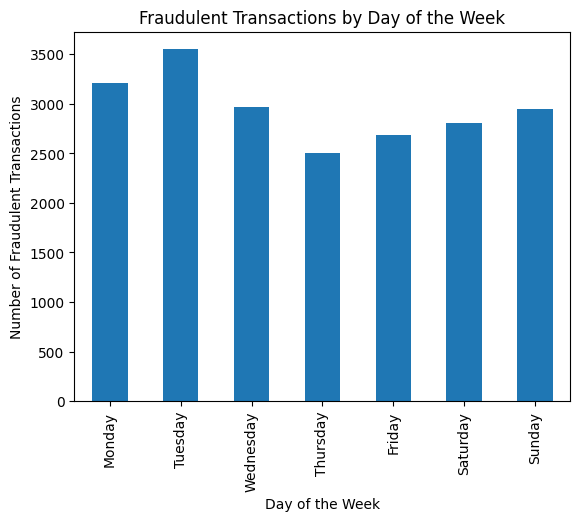

In [16]:
day_mapping = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
fraud_by_day_of_week = fraudDF.groupby('TransactionDayOfWeek').size()
fraud_by_day_of_week.index = fraud_by_day_of_week.index.map(day_mapping)
fraud_by_day_of_week.plot(kind='bar')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Fraudulent Transactions')
plt.title('Fraudulent Transactions by Day of the Week')
plt.show()
#Seems that most fraudulent transactions would take place at the beginning of the week, peaking on Tuesdays.

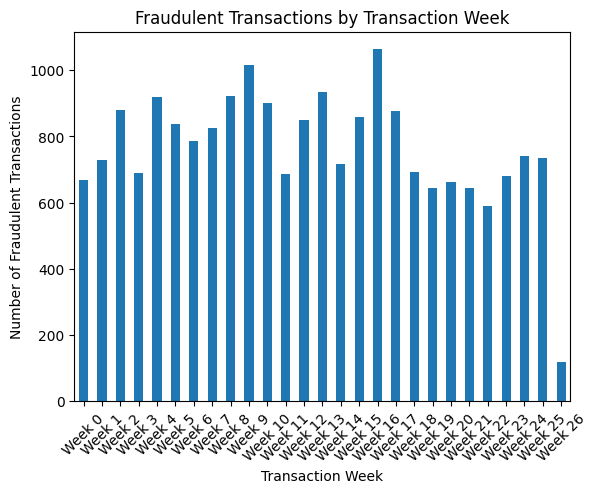

In [17]:
fraud_by_week = fraudDF.groupby('TransactionWeek').size()
fraud_by_week.index = fraud_by_week.index.map(lambda x: f'Week {x}')
fraud_by_week.plot(kind='bar')
plt.xlabel('Transaction Week')
plt.ylabel('Number of Fraudulent Transactions')
plt.title('Fraudulent Transactions by Transaction Week')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()
#The entirety of this program was 26 weeks it can be seen that the distribution is relatively unfirom with peaks at the 8th and
#16th weeks.

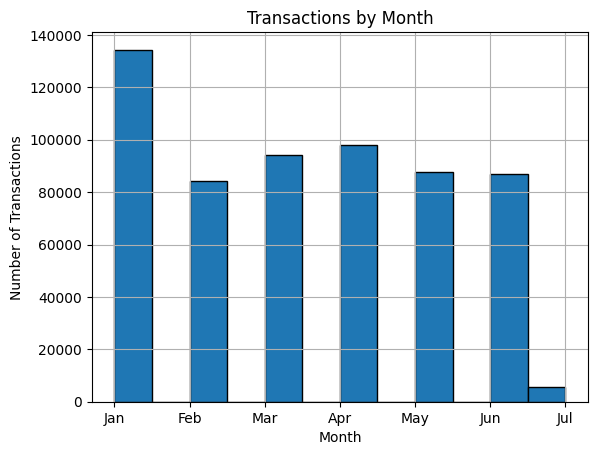

In [18]:
reference_date = pd.Timestamp("2017-01-01")  # Adjust the reference date if needed
trainDF['TransactionDate'] = trainDF['TransactionDT'].apply(lambda x: reference_date + pd.to_timedelta(x, unit='s'))

# Extract month from TransactionDate
trainDF['TransactionMonth'] = trainDF['TransactionDate'].dt.month

# Plot a histogram of transactions by month
trainDF['TransactionMonth'].hist(bins=12, edgecolor='black')
plt.xlabel('Month')
plt.ylabel('Number of Transactions')
plt.title('Transactions by Month')
plt.xticks(range(1, 8), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul'])
plt.show()
#Most transactions take place at the beginning of the year. This makes sense as that time of year is known to contain high
#amounts of spending across the world. 

/var/folders/8n/l_2zns4502ggdwb9_1j1mw8h0000gn/T/ipykernel_3683/3109281055.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frauddf['TransactionDate'] = frauddf['TransactionDT'].apply(lambda x: reference_date + pd.to_timedelta(x, unit='s'))
/var/folders/8n/l_2zns4502ggdwb9_1j1mw8h0000gn/T/ipykernel_3683/3109281055.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frauddf['TransactionMonth'] = frauddf['TransactionDate'].dt.month


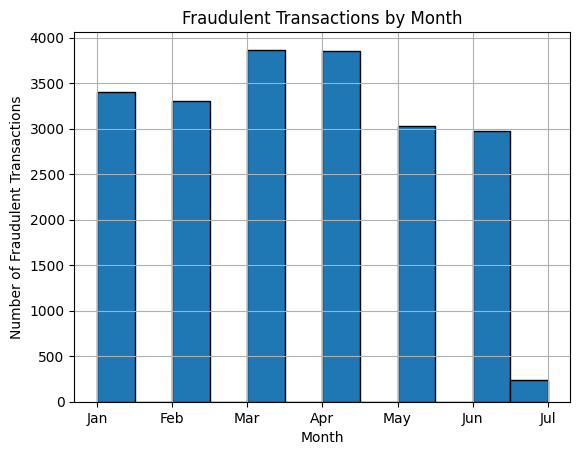

In [19]:
reference_date = pd.Timestamp("2017-01-01")  # Adjust the reference date if needed

# Filter for fraudulent transactions
frauddf = trainDF[trainDF['isFraud'] == 1]

# Convert TransactionDT to datetime format for fraudulent transactions
frauddf['TransactionDate'] = frauddf['TransactionDT'].apply(lambda x: reference_date + pd.to_timedelta(x, unit='s'))

# Extract month from TransactionDate
frauddf['TransactionMonth'] = frauddf['TransactionDate'].dt.month

# Plot a histogram of fraudulent transactions by month
frauddf['TransactionMonth'].hist(bins=12, edgecolor='black')
plt.xlabel('Month')
plt.ylabel('Number of Fraudulent Transactions')
plt.title('Fraudulent Transactions by Month')
plt.xticks(range(1, 8), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul'])
plt.show()
#All fraudulent transactions seem to be equivalently distributed across the year. This invalidates my previous 
#hypothesis as most fraudulent transactions are happening towards the middle of the year, not the beginning.

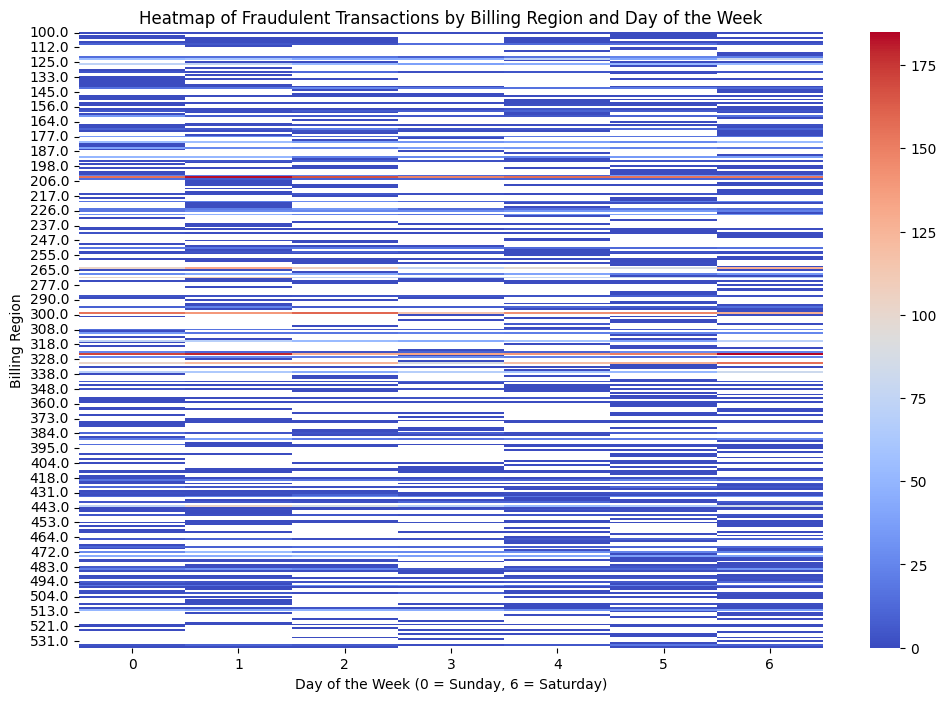

In [20]:
np.random.seed(42)
addr1_fraud_pivot = pd.pivot_table(trainDF, values='isFraud', index='addr1', columns='TransactionDayOfWeek', aggfunc='sum')

# Plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(addr1_fraud_pivot, cmap='coolwarm', annot=False, cbar=True)
plt.title('Heatmap of Fraudulent Transactions by Billing Region and Day of the Week')
plt.xlabel('Day of the Week (0 = Sunday, 6 = Saturday)')
plt.ylabel('Billing Region')
plt.show()